In [1]:
import os
import time
import json
import copy
import torch
import numpy as np
import torch.nn as nn
from PIL import Image
from IPython.display import Image
from IPython.core.display import HTML 
from torch.utils import data
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision.models as models
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
batch_size = 64
z_dim = 100
c_dim = 200
image_shape = (64, 64, 3)
lr = 0.0002
epochs = 200

In [3]:
def get_iCLEVR_data(root_folder,mode):
    if mode == 'train':
        data = json.load(open(os.path.join(root_folder,'train.json')))
        obj = json.load(open(os.path.join(root_folder,'objects.json')))
        img = list(data.keys())
        label = list(data.values())
        for i in range(len(label)):
            for j in range(len(label[i])):
                label[i][j] = obj[label[i][j]]
            tmp = np.zeros(len(obj))
            tmp[label[i]] = 1
            label[i] = tmp
        return np.squeeze(img), np.squeeze(label)
    else:
        data = json.load(open(os.path.join(root_folder,'test.json')))
        obj = json.load(open(os.path.join(root_folder,'objects.json')))
        label = data
        for i in range(len(label)):
            for j in range(len(label[i])):
                label[i][j] = obj[label[i][j]]
            tmp = np.zeros(len(obj))
            tmp[label[i]] = 1
            label[i] = tmp
        return None, label


class ICLEVRLoader(data.Dataset):
    def __init__(self, root_folder, trans=None, cond=False, mode='train'):
        self.root_folder = root_folder
        self.mode = mode
        self.img_list, self.label_list = get_iCLEVR_data(root_folder, mode)
#         if self.mode == 'train':
#             print("> Found %d images..." % (len(self.img_list))) # > Found 18009 images...
        
        self.cond = cond
        self.num_classes = 24
        self.transform = transforms.Compose([
            transforms.Resize((64,64)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
        
                
    def __len__(self):
        """'return the size of dataset"""
        if self.mode == 'train':
            return len(self.img_list)
        else:
            return 32

    def __getitem__(self, index):
        label = self.label_list[index]
        
        if self.mode == 'train':
            path = os.path.join(self.root_folder, 'images', self.img_list[index])
            img = Image.open(path).convert('RGB')
            img = self.transform(img)
            return img, label
        else:
            return [], label


In [4]:
class evaluation_model():
    def __init__(self, device):
        #modify the path to your own path
        checkpoint = torch.load('./classifier_weight.pth')
        self.resnet18 = models.resnet18(pretrained=False)
        self.resnet18.fc = nn.Sequential(
            nn.Linear(512,24),
            nn.Sigmoid()
        )
        self.resnet18.load_state_dict(checkpoint['model'])
#         self.resnet18 = self.resnet18.cuda()
        self.resnet18 = self.resnet18.to(device)
        self.resnet18.eval()
        self.classnum = 24
    def compute_acc(self, out, onehot_labels):
        batch_size = out.size(0)
        acc = 0
        total = 0
        for i in range(batch_size):
            k = int(onehot_labels[i].sum().item())
            total += k
            outv, outi = out[i].topk(k)
            lv, li = onehot_labels[i].topk(k)
            for j in outi:
                if j in li:
                    acc += 1
        return acc / total
    def eval(self, images, labels):
        with torch.no_grad():
            #your image shape should be (batch, 3, 64, 64)
            out = self.resnet18(images)
            acc = self.compute_acc(out.cpu(), labels.cpu())
            return acc

In [5]:
class Discriminator(nn.Module):
    def __init__(self,img_shape,c_dim):
        super(Discriminator, self).__init__()
        self.H,self.W,self.C=img_shape
        self.conditionExpand=nn.Sequential(
            nn.Linear(24,self.C*self.H*self.W),
            nn.LeakyReLU()
        )
        kernel_size=(4,4)
        channels=[6,64,128,256,512]
        for i in range(1,len(channels)):
            setattr(self,'conv'+str(i),nn.Sequential(
                nn.Conv2d(channels[i-1],channels[i],kernel_size,stride=(2,2),padding=(1,1)),
                nn.BatchNorm2d(channels[i]),
                nn.LeakyReLU()
            ))
        self.conv5=nn.Conv2d(512,1,kernel_size,stride=(1,1))
        self.sigmoid=nn.Sigmoid()

    def forward(self,X,c):
        c=self.conditionExpand(c).view(-1,self.C,self.H,self.W)
        out=torch.cat((X,c),dim=1)
        out=self.conv1(out)
        out=self.conv2(out)
        out=self.conv3(out)
        out=self.conv4(out)
        out=self.conv5(out)
        out=self.sigmoid(out)
        out=out.view(-1)
        return out

    def weight_init(self,mean,std):
        for m in self._modules:
            if isinstance(self._modules[m], nn.ConvTranspose2d) or isinstance(self._modules[m], nn.Conv2d):
                self._modules[m].weight.data.normal_(mean, std)
                self._modules[m].bias.data.zero_()

In [6]:
class Generator(nn.Module):
    def __init__(self,z_dim,c_dim):
        super(Generator,self).__init__()
        self.z_dim=z_dim
        self.c_dim=c_dim
        self.conditionExpand=nn.Sequential(
            nn.Linear(24,c_dim),
            nn.ReLU()
        )
        kernel_size=(4,4)
        channels=[z_dim+c_dim,512,256,128,64]
        paddings=[(0,0),(1,1),(1,1),(1,1)]
        for i in range(1,len(channels)):
            setattr(self,'convT'+str(i),nn.Sequential(
                nn.ConvTranspose2d(channels[i-1],channels[i],kernel_size,stride=(2,2),padding=paddings[i-1]),
                nn.BatchNorm2d(channels[i]),
                nn.ReLU()
            ))
        self.convT5=nn.ConvTranspose2d(64,3,kernel_size,stride=(2,2),padding=(1,1))
        self.tanh=nn.Tanh()

    def forward(self,z,c):
        z=z.view(-1,self.z_dim,1,1)
        c=self.conditionExpand(c).view(-1,self.c_dim,1,1)
        out=torch.cat((z,c),dim=1)
        out=self.convT1(out)
        out=self.convT2(out)
        out=self.convT3(out)
        out=self.convT4(out)
        out=self.convT5(out)
        out=self.tanh(out)
        return out

    def weight_init(self,mean,std):
        for m in self._modules:
            if isinstance(self._modules[m], nn.ConvTranspose2d) or isinstance(self._modules[m], nn.Conv2d):
                self._modules[m].weight.data.normal_(mean, std)
                self._modules[m].bias.data.zero_()



In [7]:
def train(dataloader,g_model,d_model,z_dim,epochs,lr,start_epoch, show_size):

    Criterion=nn.BCELoss()
    optimizer_g=torch.optim.Adam(g_model.parameters(),lr,betas=(0.5,0.99))
    optimizer_d=torch.optim.Adam(d_model.parameters(),lr,betas=(0.5,0.99))
    Eval_model=evaluation_model(device=device)

    test_conditions = None
    for i, (_, l) in enumerate(DataLoader(ICLEVRLoader(root_folder='.', cond=True, mode='test'), batch_size=32)):
        test_conditions = l.type(torch.FloatTensor).to(device); break
    
    fixed_z = torch.randn(len(test_conditions),z_dim).type(torch.FloatTensor).to(device)
    best_score = 0

    for epoch in range(start_epoch,start_epoch+epochs):
        start = time.time()
        
        total_loss_g=0
        total_loss_d=0
        for i,(images,conditions) in enumerate(dataloader):
            g_model.train()
            d_model.train()
            batch_size=len(images)
            images = images.type(torch.FloatTensor).to(device)
            conditions = conditions.type(torch.FloatTensor).to(device)

            real = torch.ones(batch_size).to(device)
            fake = torch.zeros(batch_size).to(device)

            optimizer_d.zero_grad()

            # for real images
            predicts = d_model(images, conditions)
            loss_real = Criterion(predicts, real)
            # for fake images
            z = torch.randn(batch_size, z_dim).to(device)
            gen_imgs = g_model(z,conditions)
            predicts = d_model(gen_imgs.detach(), conditions)
            loss_fake = Criterion(predicts, fake)
            # bp
            loss_d = loss_real + loss_fake
            loss_d.backward()
            optimizer_d.step()

            for _ in range(4):
                optimizer_g.zero_grad()

                z = torch.randn(batch_size,z_dim).to(device)
                gen_imgs = g_model(z, conditions)
                predicts = d_model(gen_imgs,conditions)
                loss_g = Criterion(predicts,real)

                loss_g.backward()
                optimizer_g.step()

            total_loss_g+=loss_g.item()
            total_loss_d+=loss_d.item()

        g_model.eval()
        d_model.eval()
        with torch.no_grad():
            gen_imgs=g_model(fixed_z,test_conditions)
        score=Eval_model.eval(gen_imgs,test_conditions)
        if score>best_score:
            best_score=score
            best_model_wts=copy.deepcopy(g_model.state_dict())
            torch.save(best_model_wts,os.path.join('models',f'epoch{epoch}_score{score:.2f}.pt'))
        epoch_time = time.time() - start
        epoch_time *= 10
        if epoch%show_size==0:
            print(f'               epoch: {epoch}')
            print(f'avg loss_g: {total_loss_g/len(dataloader):.3f}  avg_loss_d: {total_loss_d/len(dataloader):.3f}')
            print(f'testing score: {score:.2f} epoch_time: {epoch_time:.2f}')
            print('---------------------------------------------')
        save_image(gen_imgs, os.path.join('results', f'epoch{epoch}.png'), nrow=8, normalize=True)


In [38]:
train_data = ICLEVRLoader(root_folder='.', mode='train')
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
generator = Generator(z_dim, c_dim).to(device)
discriminator = Discriminator(image_shape, c_dim).to(device)
generator.weight_init(mean=0,std=0.02)
discriminator.weight_init(mean=0,std=0.02)
train(train_loader, generator, discriminator, z_dim, epochs, lr, start_epoch=1, show_size=10)


               epoch: 10
avg loss_g: 1.729  avg_loss_d: 0.681
testing score: 0.38 epoch_time: 1672.03
---------------------------------------------
               epoch: 20
avg loss_g: 2.146  avg_loss_d: 0.431
testing score: 0.43 epoch_time: 1670.68
---------------------------------------------


KeyboardInterrupt: 

In [113]:
torch.save(discriminator, './models/D.pt')

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
z_dim = 100
c_dim = 200
test_conditions = None
for i, (_, l) in enumerate(DataLoader(ICLEVRLoader(root_folder='.', cond=True, mode='test'), batch_size=32)):
    test_conditions = l.type(torch.FloatTensor).to(device); break
fixed_z = torch.randn(len(test_conditions),z_dim).type(torch.FloatTensor).to(device)
        
generator = Generator(z_dim, c_dim).to(device)
generator.load_state_dict(torch.load('./models/epoch116_score0.69.pt'))
with torch.no_grad():
    gen_imgs=generator(fixed_z,test_conditions)
    score=evaluation_model(device=device).eval(gen_imgs,test_conditions)
    print(f'testing score: {score:.2f}')
    # savefig
    save_image(gen_imgs, os.path.join('results', f'new_test.png'), nrow=8, normalize=True)

testing score: 0.65


/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


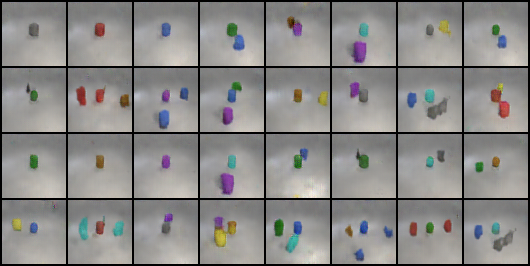

In [63]:
PATH = "./results/new_test.png"
Image(filename = PATH, width=800, height=800)